# Getting started with KerasTuner

**Authors:** Luca Invernizzi, James Long, Francois Chollet, Tom O'Malley, Haifeng Jin<br>
**Date created:** 2019/05/31<br>
**Last modified:** 2021/10/27<br>
**Description:** The basics of using KerasTuner to tune model hyperparameters.

In [ ]:
!pip install keras-tuner -q

## Introduction

KerasTuner is a general-purpose hyperparameter tuning library. It has strong
integration with Keras workflows, but it isn't limited to them: you could use
it to tune scikit-learn models, or anything else. In this tutorial, you will
see how to tune model architecture, training process, and data preprocessing
steps with KerasTuner. Let's start from a simple example.

## Tune the model architecture

The first thing we need to do is writing a function, which returns a compiled
Keras model. It takes an argument `hp` for defining the hyperparameters while
building the model.

### Define the search space

In the following code example, we define a Keras model with two `Dense` layers.
We want to tune the number of units in the first `Dense` layer. We just define
an integer hyperparameter with `hp.Int('units', min_value=32, max_value=512, step=32)`,
whose range is from 32 to 512 inclusive. When sampling from it, the minimum
step for walking through the interval is 32.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            activation=hp.Choice("activation",["relu","tanh"]),
        )
    )
    model.add(layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
    )
    return model


You can quickly test if the model builds successfully.

In [ ]:
import keras_tuner

build_model(keras_tuner.HyperParameters())

There are many other types of hyperparameters as well. We can define multiple
hyperparameters in the function. In the following code, we tune whether to
use a `Dropout` layer with `hp.Boolean()`, tune which activation function to
use with `hp.Choice()`, tune the learning rate of the optimizer with
`hp.Float()`.

In [ ]:

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units1", min_value=20, max_value=50, step=5),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )

    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=hp.Float("dropout_rate",min_value=0.25,max_value=0.6,sampling="log")))
    model.add(layers.Dense(10, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(keras_tuner.HyperParameters())

As shown below, the hyperparameters are actual values. In fact, they are just
functions returning actual values. For example, `hp.Int()` returns an `int`
value. Therefore, you can put them into variables, for loops, or if
conditions.

In [ ]:
hp = keras_tuner.HyperParameters()
print(hp.Int("units", min_value=32, max_value=512, step=32))

32


You can also define the hyperparameters in advance and keep your Keras code in
a separate function.

In [ ]:

def call_existing_code(units, activation, dropout, lr):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    if dropout:
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        units=units, activation=activation, dropout=dropout, lr=lr
    )
    return model


build_model(keras_tuner.HyperParameters())

Each of the hyperparameters is uniquely identified by its name (the first
argument). To tune the number of units in different `Dense` layers separately
as different hyperparameters, we give them different names as `f"units_{i}"`.

Notably, this is also an example of creating conditional hyperparameters.
There are many hyperparameters specifying the number of units in the `Dense`
layers. The number of such hyperparameters is decided by the number of layers,
which is also a hyperparameter. Therefore, the total number of hyperparameters
used may be different from trial to trial. Some hyperparameter is only used
when a certain condition is satisfied. For example, `units_3` is only used
when `num_layers` is larger than 3. With KerasTuner, you can easily define
such hyperparameters dynamically while creating the model.

In [ ]:

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(keras_tuner.HyperParameters())

### Start the search

After defining the search space, we need to select a tuner class to run the
search. You may choose from `RandomSearch`, `BayesianOptimization` and
`Hyperband`, which correspond to different tuning algorithms. Here we use
`RandomSearch` as an example.

To initialize the tuner, we need to specify several arguments in the initializer.

* `hypermodel`. The model-building function, which is `build_model` in our case.
* `objective`. The name of the objective to optimize (whether to minimize or
maximize is automatically inferred for built-in metrics). We will introduce how
to use custom metrics later in this tutorial.
* `max_trials`. The total number of trials to run during the search.
* `executions_per_trial`. The number of models that should be built and fit for
each trial. Different trials have different hyperparameter values. The
executions within the same trial have the same hyperparameter values. The
purpose of having multiple executions per trial is to reduce results variance
and therefore be able to more accurately assess the performance of a model. If
you want to get results faster, you could set `executions_per_trial=1` (single
round of training for each model configuration).
* `overwrite`. Control whether to overwrite the previous results in the same
directory or resume the previous search instead. Here we set `overwrite=True`
to start a new search and ignore any previous results.
* `directory`. A path to a directory for storing the search results.
* `project_name`. The name of the sub-directory in the `directory`.

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

You can print a summary of the search space:

In [ ]:
tuner.search_space_summary()

Before starting the search, let's prepare the MNIST dataset.

In [ ]:
from tensorflow import keras
import numpy as np

(x, y), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x[:-10000]
x_val = x[-10000:]
y_train = y[:-10000]
y_val = y[-10000:]

x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_val = np.expand_dims(x_val, -1).astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Then, start the search for the best hyperparameter configuration.
All the arguments passed to `search` is passed to `model.fit()` in each
execution. Remember to pass `validation_data` to evaluate the model.

In [ ]:
tuner.search(x_train, y_train, epochs=2, validation_data=(x_val, y_val))

During the `search`, the model-building function is called with different
hyperparameter values in different trial. In each trial, the tuner would
generate a new set of hyperparameter values to build the model. The model is
then fit and evaluated. The metrics are recorded. The tuner progressively
explores the space and finally finds a good set of hyperparameter values.

### Query the results

When search is over, you can retrieve the best model(s). The model is saved at
its best performing epoch evaluated on the `validation_data`.

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.predict(X_test)

You can also print a summary of the search results.

In [ ]:
tuner.results_summary()

You will find detailed logs, checkpoints, etc, in the folder
`my_dir/helloworld`, i.e. `directory/project_name`.

You can also visualize the tuning results using TensorBoard and HParams plugin.
For more information, please following
[this link](https://keras.io/guides/keras_tuner/visualize_tuning/).

### Retrain the model

If you want to train the model with the entire dataset, you may retrieve the
best hyperparameters and retrain the model by yourself.

# Optuna

In [ ]:
!pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/4c/6a/219a431aaf81b3eb3070fd2d58116baa366d3072f43bbcc87dc3495b7546/optuna-3.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/f3/18/3e867ab37a24fdf073c1617b9c7830e06ec270b1ea4694a624038fc40a03/colorlog-6.8.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/413.4 kB ? eta -:--:--
   -- ------------------------------------- 30.7/413.4 kB 1.4 MB/s eta 0:00:01
   ----------- ---------------------------- 122.9/413.4 kB 1.4 MB/s eta 0:00:01
   ------------------------ --------------- 256.0/413.4 kB 2.0 MB/s eta 0:00:01
   ------------------------------------- -- 389.1/413.4 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 413.4/413.4 kB 2.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import optuna

# 1. Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 2. Define the model architecture using the Keras functional API
def create_model(trial):
    inputs = Input(shape=(28, 28))
    x = Flatten()(inputs)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 32, 512)
        x = Dense(num_hidden, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# 3. Define the objective function for Optuna
def objective(trial):
    model = create_model(trial)
    optimizer_options = ['adam', 'sgd']
    optimizer = trial.suggest_categorical('optimizer', optimizer_options)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    epochs = 10  # Keeping epochs fixed for demonstration; you might want to tune this as well

    model.fit(x_train, y_train, validation_split=0.2, shuffle=True, batch_size=batch_size, epochs=epochs, verbose=0)

    # Evaluate the model accuracy on the validation set
    score = model.evaluate(x_test, y_test, verbose=0)
    return score[1]  # Return the accuracy

# 4. Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # You can increase n_trials for a more thorough search

# 5. Print the best hyperparameters
print('Best trial:', study.best_trial.params)

# Optional: Evaluate the best model on the test set
best_model = create_model(study.best_trial)
best_model.compile(optimizer=study.best_trial.params['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'])
best_model.fit(x_train, y_train, batch_size=study.best_trial.params['batch_size'], epochs=10, verbose=1)
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_acc}, Test Loss: {test_loss}')


[I 2024-03-01 19:42:46,689] A new study created in memory with name: no-name-fc62d8a9-0238-4385-a494-14083c62c093
[I 2024-03-01 19:42:51,742] Trial 0 finished with value: 0.907800018787384 and parameters: {'n_layers': 2, 'n_units_l0': 78, 'n_units_l1': 115, 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 0 with value: 0.907800018787384.
[I 2024-03-01 19:42:59,597] Trial 1 finished with value: 0.979200005531311 and parameters: {'n_layers': 1, 'n_units_l0': 259, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 1 with value: 0.979200005531311.
[I 2024-03-01 19:43:06,731] Trial 2 finished with value: 0.9757000207901001 and parameters: {'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 97, 'n_units_l2': 315, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 1 with value: 0.979200005531311.
[I 2024-03-01 19:43:16,444] Trial 3 finished with value: 0.9782000184059143 and parameters: {'n_layers': 3, 'n_units_l0': 369, 'n_units_l1': 182, 'n_units_l2': 289, 'optimizer': 'adam', 'ba

Best trial: {'n_layers': 1, 'n_units_l0': 259, 'optimizer': 'adam', 'batch_size': 128}
Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.3017 - accuracy: 0.9157
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1340 - accuracy: 0.9616
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0903 - accuracy: 0.9737
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0662 - accuracy: 0.9807
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0515 - accuracy: 0.9850
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0397 - accuracy: 0.9885
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0316 - accuracy: 0.9912
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0248 - accuracy: 0.9933
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0198 - accuracy: 0.9947
Epoch 10/10
3

## Let's takl about Pruners!!

Optuna offers several mechanisms to improve the efficiency of hyperparameter searches, among which pruning is a key feature. Pruning allows Optuna to stop the execution of a trial if it judges that the trial is unlikely to lead to the best results. This judgement is based on the intermediate results of the trial, such as validation loss or accuracy, at various points during training. The idea is to cut short the computation time for unpromising trials, thus allocating more resources to more promising ones.

### MedianPruner

The `MedianPruner` is one of the pruners provided by Optuna. It uses the median of intermediate results of all trials at similar points in time as a threshold for pruning. If the performance of a trial is below the median at a given checkpoint, that trial is stopped early. This pruner is straightforward and works well for a wide range of problems. However, it assumes that a significant number of trials will not be pruned, to accurately estimate the median performance.

The `MedianPruner` operates at the level of the Optuna study, influencing which trials continue based on the comparison of each trial's performance against the median performance of all trials.

### TFKerasPruningCallback

The `TFKerasPruningCallback` is a specific callback for TensorFlow/Keras models that integrates with Optuna's pruning mechanism. It is used within the training loop of a Keras model to check the condition for pruning at the end of every epoch. The callback communicates with the Optuna trial to decide whether the current trial should be stopped based on the intermediate results (like validation accuracy or loss).

The callback interacts with the pruner specified in the Optuna study (such as the `MedianPruner`) to make pruning decisions. When the callback determines that a trial should be pruned, it interrupts the training process of the current Keras model.

### How They Work Together

1. **Setup**: You define an Optuna study and specify a pruner, such as the `MedianPruner`. This pruner will be used to make decisions about stopping trials early based on the criteria set by the pruner (e.g., comparison with the median performance).

2. **Trial Execution**: During each trial, as your Keras model trains, the `TFKerasPruningCallback` checks the intermediate results after each epoch and consults with the pruner (in this case, the `MedianPruner`) to determine whether the trial's performance is promising.

3. **Pruning Decision**: If the pruner decides that the trial is unlikely to result in a top-performing model (e.g., if the trial's performance is below the median), the `TFKerasPruningCallback` stops the trial early. This decision is made at the epoch level, allowing Optuna to save time by not completing the full training process for that trial.

4. **Resource Allocation**: Resources are then reallocated to new trials, which may have a better chance of finding optimal hyperparameters.

In summary, the `MedianPruner` provides the strategy for deciding whether a trial should be stopped based on the comparison of its performance to the median performance of other trials. The `TFKerasPruningCallback` is the mechanism through which this strategy is applied to TensorFlow/Keras models, allowing Optuna to prune trials that are underperforming according to the criteria set by the `MedianPruner`.

In [ ]:
!pip install optuna-integration

  Obtaining dependency information for optuna-integration from https://files.pythonhosted.org/packages/7f/55/92afe61e1dc07a00c8e4eb7feabf6c06b88f8276bc748068cb62c035a3f6/optuna_integration-3.5.0-py3-none-any.whl.metadata


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import optuna
from optuna.integration import TFKerasPruningCallback

# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the model architecture using the Keras functional API
def create_model(trial):
    inputs = Input(shape=(28, 28))
    x = Flatten()(inputs)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 32, 512)
        x = Dense(num_hidden, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define the objective function for Optuna
def objective(trial):
    model = create_model(trial)
    optimizer_options = ['adam', 'sgd']
    optimizer = trial.suggest_categorical('optimizer', optimizer_options)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    epochs = 10  # Keeping epochs fixed for demonstration; you might want to tune this as well

    # Add a Keras pruning callback
    callbacks = [TFKerasPruningCallback(trial, 'val_accuracy')]

    model.fit(x_train, y_train, validation_split=0.2, shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)

    # Evaluate the model accuracy on the validation set
    score = model.evaluate(x_test, y_test, verbose=0)
    return score[1]  # Return the accuracy

# Run the Optuna study
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10)  # You can increase n_trials for a more thorough search

# Print the best hyperparameters
print('Best trial:', study.best_trial.params)


[I 2024-03-01 19:44:29,943] A new study created in memory with name: no-name-21aca0b0-20d9-499a-a143-4b6e3c03e8da
[I 2024-03-01 19:44:46,992] Trial 0 finished with value: 0.965399980545044 and parameters: {'n_layers': 2, 'n_units_l0': 243, 'n_units_l1': 431, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 0 with value: 0.965399980545044.
[I 2024-03-01 19:45:02,157] Trial 1 finished with value: 0.9363999962806702 and parameters: {'n_layers': 2, 'n_units_l0': 370, 'n_units_l1': 477, 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 0 with value: 0.965399980545044.
[I 2024-03-01 19:45:18,436] Trial 2 finished with value: 0.9790999889373779 and parameters: {'n_layers': 3, 'n_units_l0': 460, 'n_units_l1': 292, 'n_units_l2': 414, 'optimizer': 'adam', 'batch_size': 256}. Best is trial 2 with value: 0.9790999889373779.
[I 2024-03-01 19:45:33,297] Trial 3 finished with value: 0.9785000085830688 and parameters: {'n_layers': 2, 'n_units_l0': 471, 'n_units_l1': 174, 'optimizer': 'adam',

Best trial: {'n_layers': 3, 'n_units_l0': 460, 'n_units_l1': 292, 'n_units_l2': 414, 'optimizer': 'adam', 'batch_size': 256}


# Needs to be changed

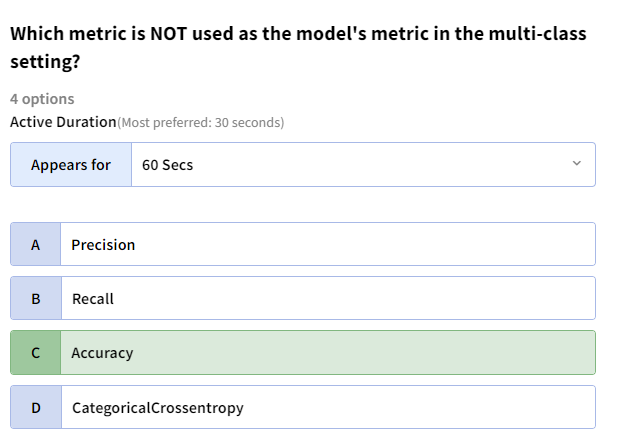

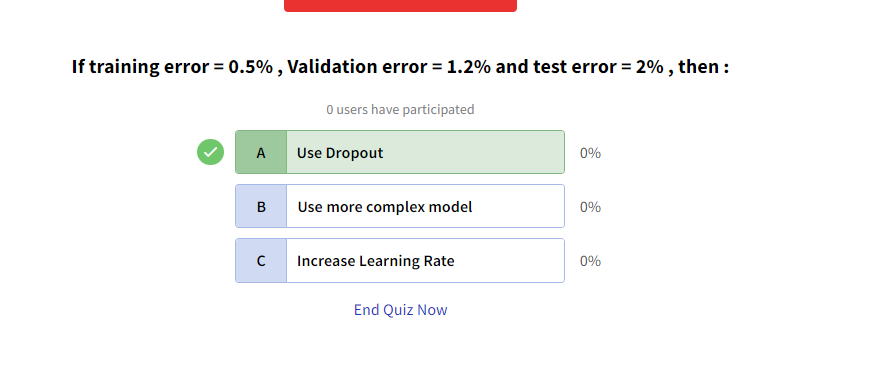